In [5]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, colors as colors
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
from TESStools import *
from sys import path
path.append('../../JazzHands/')
from jazzhands import *

In [2]:
massive_observed = pd.read_csv('../data/massive_observed.csv')
lbvs = massive_observed[massive_observed['SpT']=='LBV'].reset_index(drop=True)
#let's add in T_effs and Ls
logT_q = [4.26,4.26,4.23,4.58,4.3,4.4,4.46]
logL = [5.70,6.1,6.3,5.68,5.82,6.54,5.80]
source = ['1','1','1','4','2,3','2','4']
names = ['P Cyg','$\zeta^1$ Sco$^*$','HD 80077$^*$','HD 148937$^*$','S Dor','$\eta$ Car','HD 269582']
source_dict = {'1':'clark05b','2':'humphreys94','3':'lamers95','4':'vangenderen01'}
lbvs['logT_q'] = logT_q
lbvs['logL'] = logL
lbvs['Spec_source'] = source
lbvs['TeX_name'] = names
lbvs.sort_values('logT_q',inplace=True)
lbvs = lbvs[lbvs['CommonName'] != '* eta Car'].reset_index(drop=True)
lbvs

TIC ID          RA        Dec      dist      pmRA     pmDec     Tmag  \
0  391624171  138.978279 -49.973493  0.039651 -5.295830  4.813780   5.7508   
1   12149245  304.446674  38.032930  0.054074 -3.498230 -6.819400   4.2616   
2  246962305  253.498863 -42.362032  0.035873  0.008812 -2.939490   4.3819   
3  179305185   79.559822 -69.250319  0.051135  1.734760  0.279512   7.4155   
4  279957111   81.969425 -68.985691  0.078509  1.739400  0.485263  10.5263   
5   21931623  248.468278 -48.111244  0.040351  0.880148 -3.381430   6.4483   

   ContRatio  SpT   CommonName  MKType SimbadOType   SimbadSpT  logT_q  logL  \
0        NaN  LBV    HD  80077       B     BlueSG*      B2Ia+e    4.23  6.30   
1        NaN  LBV      * P Cyg    B2pe     BlueSG*  B1-2Ia-0ep    4.26  5.70   
2        NaN  LBV  * zet01 Sco     B1p     BlueSG*    B1Ia-0ek    4.26  6.10   
3        NaN  LBV     V* S Dor  A5Iaeq         SG*      A5Iaeq    4.30  5.82   
4        NaN  LBV    HD 269582     NaN         WR*       WN10h    4.46  5.80   
5        NaN  LBV    HD 148937      B0         SB*       O6f?p    4.58  5.68   

  Spec_source           TeX_name  
0           1       HD 80077$^*$  
1           1              P Cyg  
2           1  $\zeta^1$ Sco$^*$  
3         2,3              S Dor  
4           4          HD 269582  
5           4      HD 148937$^*$

In [51]:
from tqdm.notebook import tqdm
RMs = []
RPs = []
eps = np.logspace(-3,-1,100)

for idx,row in lbvs.iterrows():
    
    print(row['CommonName'])
    
    tic = row['TIC ID']
    lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    
    center_time = time[(time>=time.min()-6) & (time<=time.max()+6)][::10]
    vec = np.empty((len(center_time),6))

    tau = 0.666

    for i in range(6):
        dt = (center_time - i*tau).values
        f = np.interp(dt, time, flux)
        vec[:,i] = f
        
    RM = np.zeros((vec.shape[0],vec.shape[0]))
        
    for i in tqdm(range(vec.shape[0])):
        for j in range(i, vec.shape[0]):
            RM[i,j] = np.linalg.norm(vec[i,:]-vec[j,:])
    np.fill_diagonal(RM, 0)    
    RM += RM.T
    RMs.append(RM)
    
    RR = []
    for e in tqdm(eps):
        clipped = np.heaviside(e-RM,1)
        RR.append(clipped.sum()/(RM.shape[0]**2.0))
    e_30 = eps[np.argmin(np.abs(np.array(RR)-0.3))]
    RPs.append(np.heaviside(e_30-RM,1))

HD  80077



* P Cyg



* zet01 Sco



V* S Dor



HD 269582



HD 148937


HD  80077
* P Cyg
* zet01 Sco
V* S Dor
HD 269582
HD 148937


(0, 0.01)

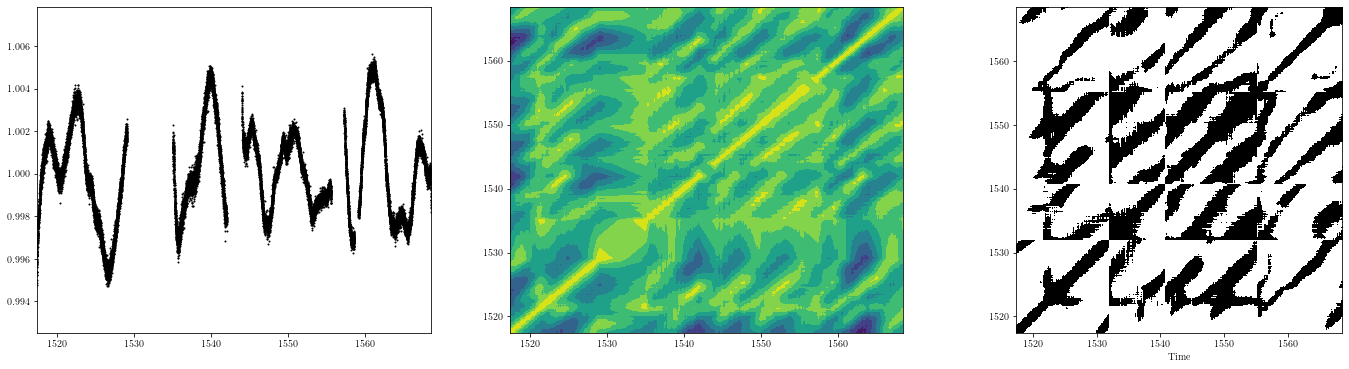

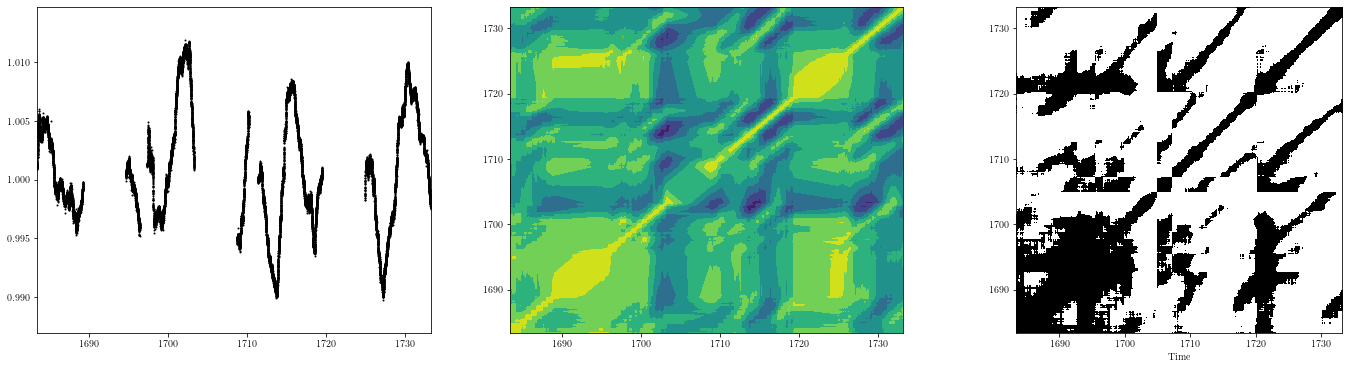

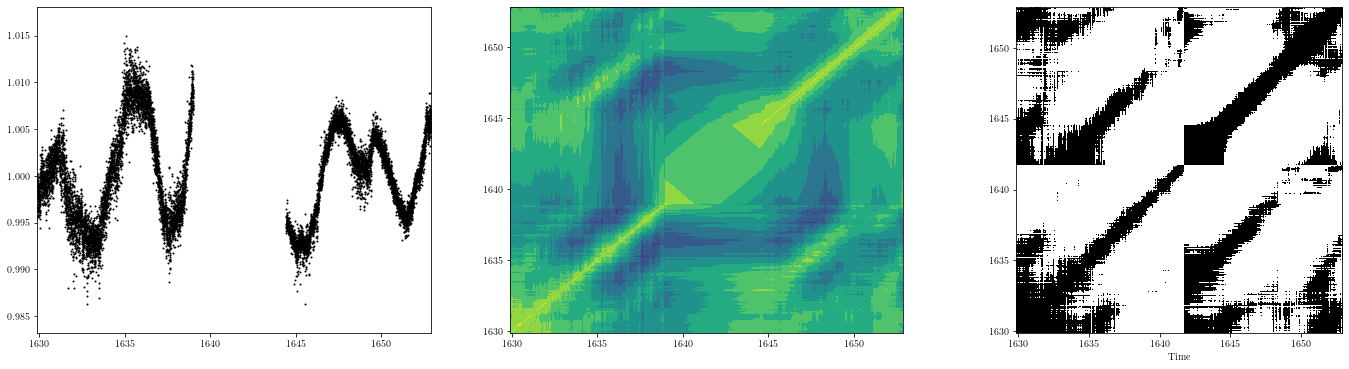

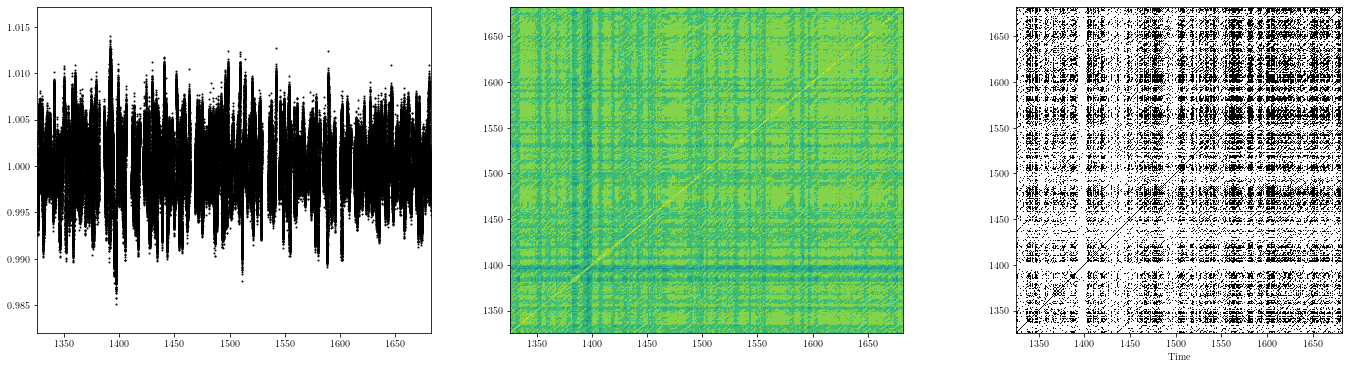

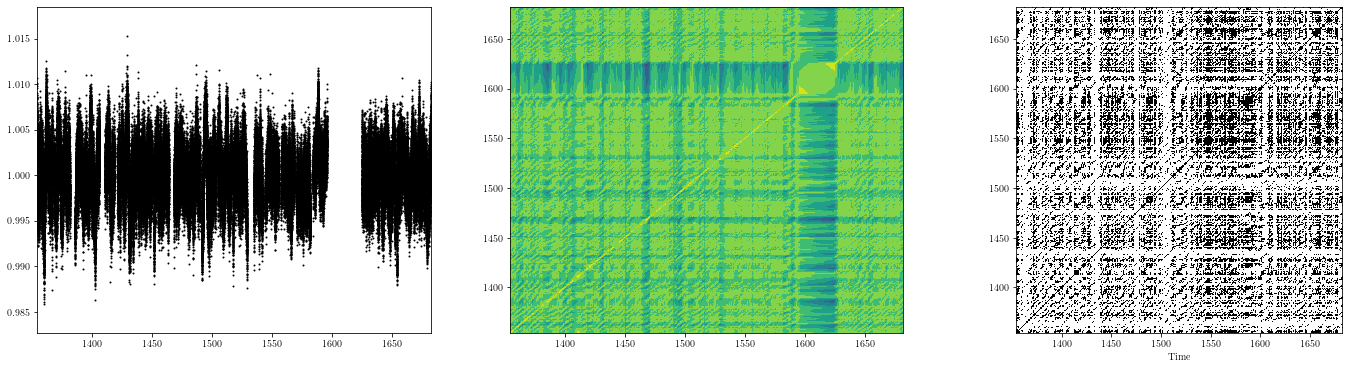

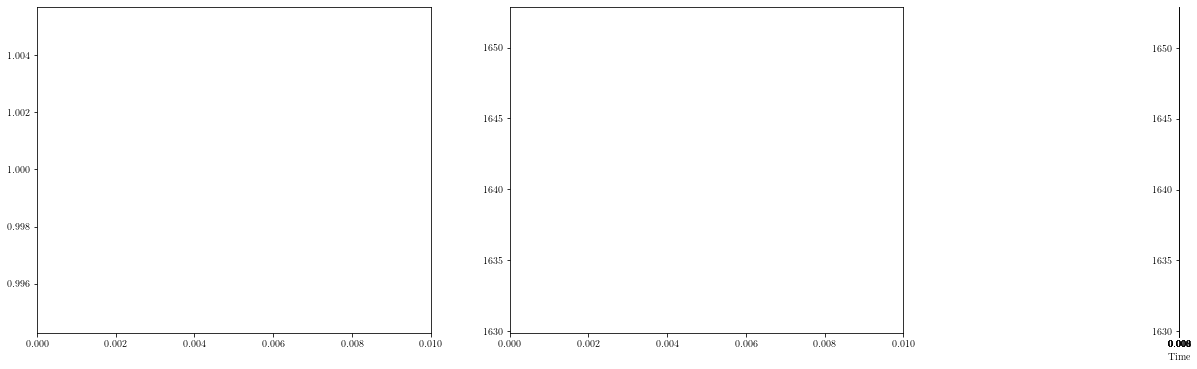

In [52]:
for idx,row in lbvs.iterrows():
    
    print(row['CommonName'])
    
    tic = row['TIC ID']
    lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    
    center_time = time[(time>=time.min()-6) & (time<=time.max()+6)][::10]
    
    RM = RMs[idx]
    RP = RPs[idx]
    
    fig, ax = plt.subplots(1,3,figsize=(24,6),sharex=True)

    ax[0].scatter(time, flux, s=1,c='k')
    
    ax[1].contourf(center_time[::5],center_time[::5],RM[::5,::5].mean()-RM[::5,::5])
    
    ax[2].imshow(RP, origin='lower',extent=(center_time.min(),center_time.max(),center_time.min(),center_time.max()), cmap='binary')
    ax[2].set(xlim=(center_time.min(),center_time.max()),xlabel='Time')
    
    plt.savefig(row['CommonName']+'_recurrence_matrix.png')

3 V* S Dor
(21251, 21251)


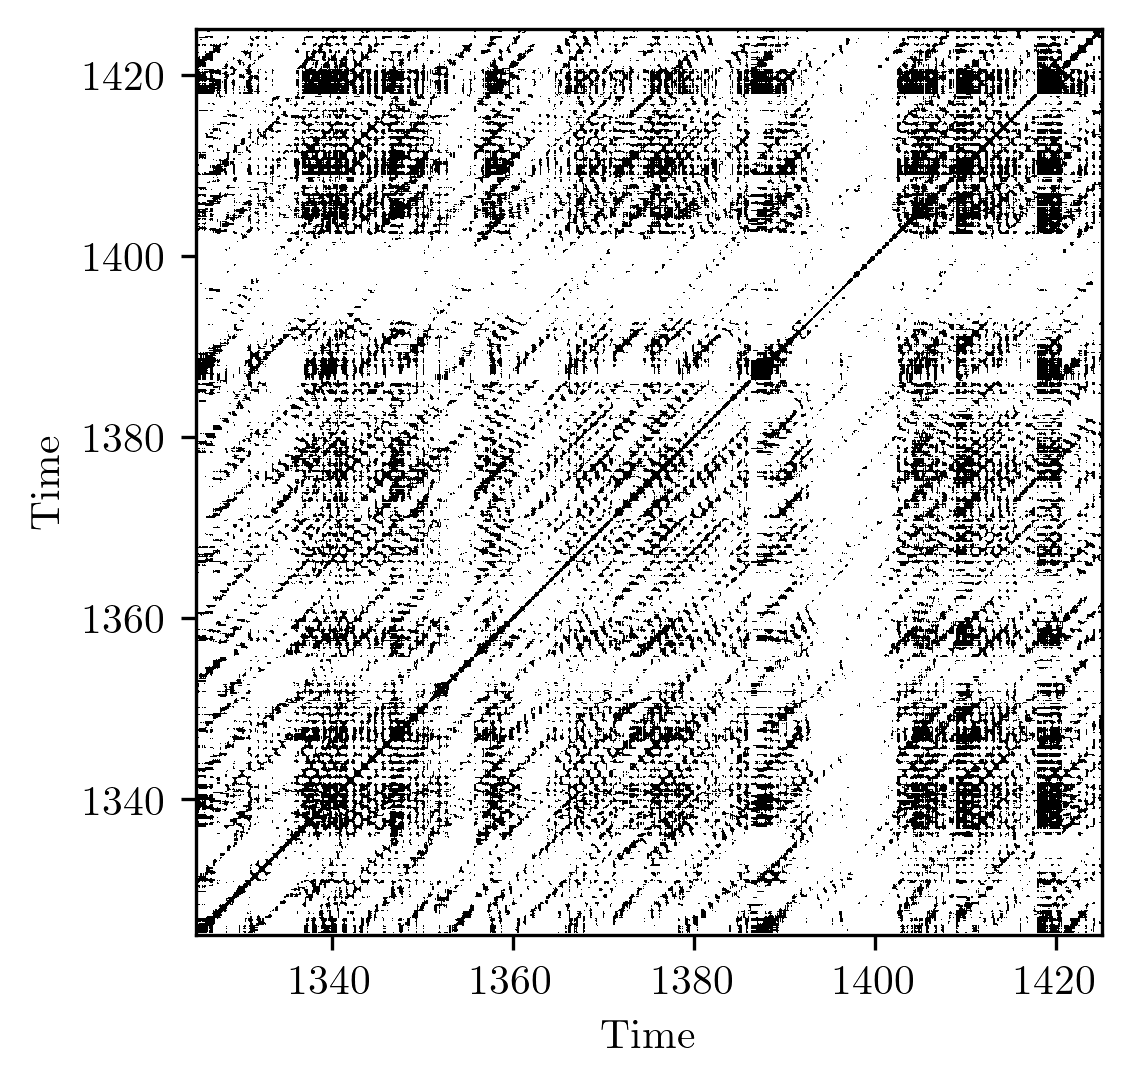

In [53]:
for idx,row in lbvs.iterrows():
    
    if row['CommonName'] == 'V* S Dor':
        print(idx,row['CommonName'])
    
        tic = row['TIC ID']
        lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
        time, flux, err = lc['Time'], lc['Flux'], lc['Err']

        center_time = time[(time>=time.min()-6) & (time<=time.max()+6)][::10]

        RP = RPs[idx]
        
        print(RP.shape)
        
        fig = plt.figure(dpi=300)
        ax = plt.subplot(111)
        ax.imshow(RP, origin='lower',extent=(center_time.min(),center_time.max(),center_time.min(),center_time.max()), cmap='binary')
        ax.set(xlim=(1325,1425),ylim=(1325,1425),xlabel='Time',ylabel='Time')

        plt.savefig('../../Proposals/NSF_AAPF/Sdor_recurrence.pdf')

In [ ]:
x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
y = np.sin(x)
tck = interpolate.splrep(x, y, s=0)
xnew = np.arange(0, 2*np.pi, np.pi/50)
ynew = interpolate.splev(xnew, tck, der=0)

3 V* S Dor
V* S Dor


(0.99, 1.01)

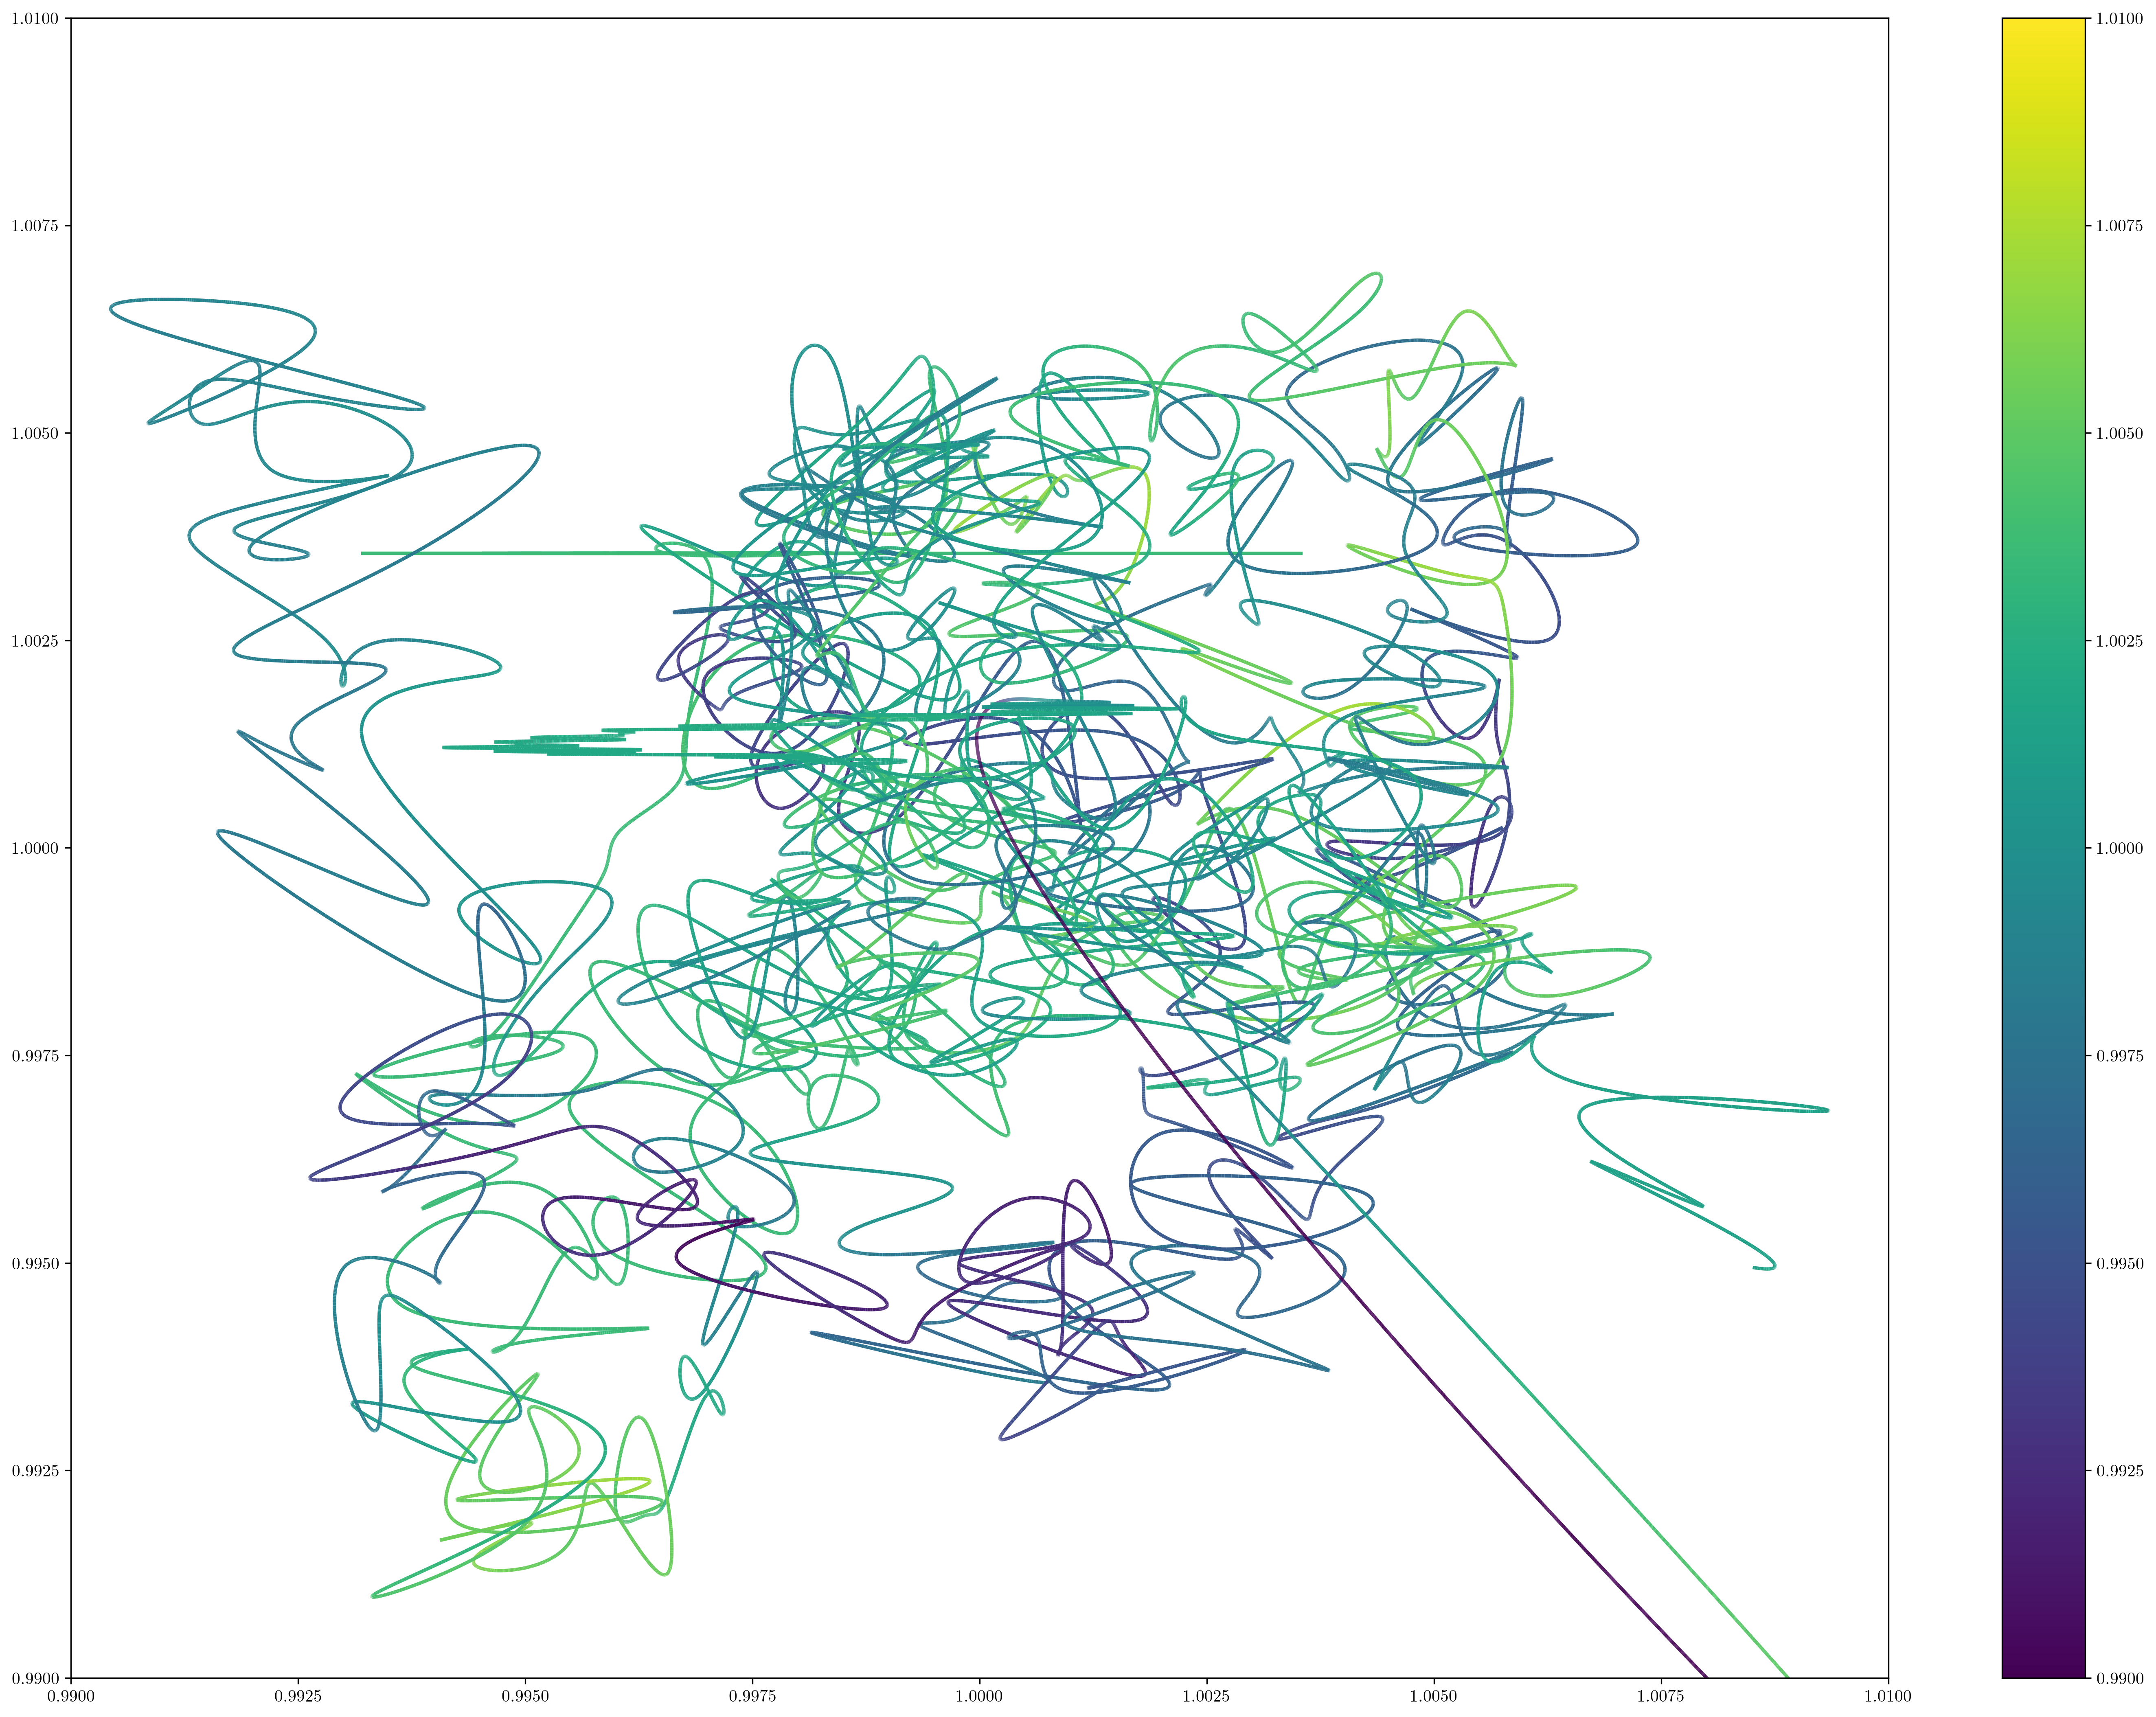

In [70]:
fig=plt.figure(dpi=300,figsize=(24,18))
for idx,row in lbvs.iterrows():
    
    
    if row['CommonName'] == 'V* S Dor':
        print(idx,row['CommonName'])
    
        tic = row['TIC ID']
        lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
        time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    
        print(row['CommonName'])

        tic = row['TIC ID']
        lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
        time, flux, err = lc['Time'], lc['Flux'], lc['Err']

        center_time = time[(time>=time.min()-6) & (time<=time.max()+6)][::10]
        vec = np.empty((len(center_time),6))

        tau = 0.666

        for i in range(6):
            dt = (center_time - i*tau).values
            f = np.interp(dt, time, flux)
            vec[:,i] = f

from scipy import interpolate
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

t = center_time[:1000]
y_0 = vec[:1000,0]
y_1 = vec[:1000,1]
y_2 = vec[:1000,2]
tck_0 = interpolate.splrep(t, y_0, s=0)
tck_1 = interpolate.splrep(t, y_1, s=0)
tck_2 = interpolate.splrep(t, y_2, s=0)
tnew = np.linspace(t.min(), t.max(), 1e5)
new_0 = interpolate.splev(tnew, tck_0, der=0)
new_1 = interpolate.splev(tnew, tck_1, der=0)
new_2 = interpolate.splev(tnew, tck_2, der=0)

points = np.array([new_0, new_1]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(0.99, 1.01)
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(new_2)
lc.set_linewidth(2)
line = plt.gca().add_collection(lc)
fig.colorbar(line, ax=fig.gca())


plt.xlim(0.99,1.01)
plt.ylim(0.99,1.01)

In [77]:
import astropy.units as u
ls = LombScargle(time*u.day, flux*u.ct/u.second)
freq, power = ls.autopower()
freq = freq* 1/u.day
freq.to(u.Hz) * 1e6

<Quantity [3.24148424e-03, 9.72445273e-03, 1.62074212e-02, ...,
           1.72211792e+04, 1.72211857e+04, 1.72211922e+04] Hz>

In [95]:
from astroML.time_series import ACF_scargle
C_S, t_S = ACF_scargle(time, flux, err,
                       n_omega=2. ** 12, omega_max=2*np.pi*20)

ind = (t_S >= 0) & (t_S <= 10)
t_S = t_S[ind]
C_S = C_S[ind]

        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]
        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]


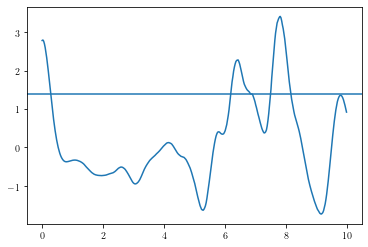

In [97]:
plt.plot(t_S, C_S)
plt.axhline(y=C_S[0]/2)

In [100]:
t_S[np.argmin(np.abs(C_S[t_S<2]-0.5*C_S[0]/np.e))]

0.40009765625